In [1]:
import json
from functools import partial

import pandas as pd
import pyproj
import numpy as np
import shapely.ops as ops
from tqdm import tqdm
from shapely.geometry import shape

import matplotlib.pyplot as plt
import mplleaflet

from city_conf import city_mappings

## Map data results

In [ ]:
def find_polygon_area(geojson):
    geom = shape(geojson)
    geom_area = ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea',
                lat_1=geom.bounds[1],
                lat_2=geom.bounds[3]
            )
        ),
        geom)
    return geom_area.area / 1e6

In [ ]:
experiment_name = "data/2023-01-10/"

city_records = []
for country_map in city_mappings:
    for city in city_mappings[country_map]:
        city_name = list(city.keys())[0]
        osm_id = city[city_name]["osm_id"]
        try:
            with open(f"{experiment_name}/results/{city_name}.json", "r") as f:
                city_record = json.load(f)

            with open(f"{experiment_name}/city_polygons/{city_name.lower()}_polygon.geojson") as f:
                city_polygon = json.load(f)

            city_record["osm_id"] = osm_id
            city_record["area_km2"] = find_polygon_area(city_polygon)
            city_records.append(city_record)
        except:
            continue

In [ ]:
df = pd.DataFrame(city_records)

In [ ]:
df

In [ ]:
city_records_with_decay = []
for country_map in city_mappings:
    for city in city_mappings[country_map]:
        city_name = list(city.keys())[0]
        osm_id = city[city_name]["osm_id"]
        try:
            with open(f"{experiment_name}/results/{city_name}_decay.json", "r") as f:
                city_record = json.load(f)

            with open(f"{experiment_name}/city_polygons/{city_name.lower()}_polygon.geojson") as f:
                city_polygon = json.load(f)

            city_record["osm_id"] = osm_id
            city_record["area_km2"] = find_polygon_area(city_polygon)
            city_records_with_decay.append(city_record)
        except:
            continue

In [ ]:
df_decay = pd.DataFrame(city_records_with_decay)

In [ ]:
df_decay

In [ ]:
df["overall_road_length"] = df["total_cycling_road_length"] + df["total_road_length"]
df_decay["overall_road_length"] = df_decay["total_cycling_road_length"] + df_decay["total_road_length"]

In [ ]:
df["cycle_road_share"] = df["total_cycling_road_length"] / df["overall_road_length"]
df_decay["cycle_road_share"] = df_decay["total_cycling_road_length"] / df_decay["overall_road_length"]

In [ ]:
df["cycle_track_share"] = df["total_cycle_track_length"] / df["overall_road_length"]
df_decay["cycle_track_share"] = df_decay["total_cycle_track_length"] / df_decay["overall_road_length"]

In [ ]:
df["cycle_lane_share"] = df["total_cycle_lane_length"] / df["overall_road_length"]
df_decay["cycle_lane_share"] = df_decay["total_cycle_lane_length"] / df_decay["overall_road_length"]

In [ ]:
df["segregated_cycle_track_share"] = df["total_segregated_cycle_track_length"] / df["overall_road_length"]
df_decay["segregated_cycle_track_share"] = df_decay["total_segregated_cycle_track_length"] / df_decay[
    "overall_road_length"]

In [ ]:
df["rank_cycle_road_share"] = df["cycle_road_share"].rank(ascending=False).astype(int)
df["rank_cycle_track_share"] = df["cycle_track_share"].rank(ascending=False).astype(int)
df["rank_segregated_cycle_track_share"] = df["segregated_cycle_track_share"].rank(ascending=False).astype(int)

In [ ]:
df_decay["rank_cycle_road_share"] = df_decay["cycle_road_share"].rank(ascending=False).astype(int)
df_decay["rank_cycle_track_share"] = df_decay["cycle_track_share"].rank(ascending=False).astype(int)
df_decay["rank_segregated_cycle_track_share"] = df_decay["segregated_cycle_track_share"].rank(ascending=False).astype(
    int)

In [ ]:
merged = df.merge(df_decay, on=["city_name", "osm_id", "area_km2"], suffixes=["", "_decayed"])

# merged["overall_score"] = merged["cycle_road_share_decayed"] * merged["cycle_track_share_decayed"] #* merged[
#     "segregated_cycle_track_share_decayed"]
# merged["overall_score"] = merged["cycle_road_share"] * merged["segregated_cycle_track_share"]
merged["overall_score"] = merged["cycle_road_share_decayed"]
merged["overall_rank"] = merged["overall_score"].rank(ascending=False).astype(int)

In [ ]:
merged["parking_per_km2"] = merged['parking_counter'] / merged["area_km2"]

In [ ]:
# merged["rank_diff"] = (merged["cycle_road_share_decayed"] - merged["cycle_road_share"]) / merged["cycle_road_share"]

In [ ]:
merged["rank_diff"] = merged["rank_cycle_road_share"] - merged["rank_cycle_road_share_decayed"]

In [ ]:
merged.sort_values("rank_diff")

In [ ]:
### Print for web

In [ ]:
final = merged[
    ["city_name",
     "osm_id",
     "area_km2",
     "total_road_length",
     "total_cycling_road_length",
     "cycle_road_share",
     "cycle_track_share",
     "cycle_lane_share",
     "segregated_cycle_track_share",
     "cycle_road_share_decayed",
     "cycle_track_share_decayed",
     "segregated_cycle_track_share_decayed",
     "parking_per_km2",
     "overall_rank"]].round(3).rename(columns={
    "city_name": "City name",
    "osm_id": "OSM id",
    "area_km2": "Area (km2)",
    "total_road_length": "Navigable road length (km)",
    "total_cycling_road_length": "Navigable bike road length (km)",
    "cycle_road_share": "Cycle road share",
    "cycle_track_share": "Cycle track share",
    "cycle_lane_share": "Cycle lane share",
    "segregated_cycle_track_share": "Segregated track share",
    "cycle_road_share_decayed": "Cycle road share (weighted)",
    "cycle_track_share_decayed": "Cycle track share (weighted)",
    "segregated_cycle_track_share_decayed": "Segregated track share (weighted)",
    "parking_per_km2": "Parking spaces (per km2)",
    "overall_rank": "Rank"
})

In [ ]:
final_for_blog = merged[
    ["city_name",
     "osm_id",
     "area_km2",
     "total_road_length",
#      "total_cycling_road_length",
     "cycle_road_share_decayed",
#      "cycle_track_share",
#      "cycle_lane_share",
#      "segregated_cycle_track_share",
#      "cycle_road_share_decayed",
#      "cycle_track_share_decayed",
#      "segregated_cycle_track_share_decayed",
#      "parking_per_km2",
     "overall_rank"]
].round(3).rename(columns={"city_name": "City name", "osm_id": "OSM id", "area_km2": "Area (km2)", "total_road_length": "Navigable road length (km)", "cycle_road_share_decayed": "Cycle road share (weighted)", "overall_rank": "Rank"})

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
final.sort_values("Rank", ascending=True)

In [ ]:
# print(final.to_html(index=False))
with open("table.cs.html", "wt") as fout:
    fout.write(final.sort_values("Rank", ascending=True).to_html(index=False))
    
final.sort_values("Rank", ascending=True).to_csv("table.cs.csv", index=False)

In [ ]:
print(final_for_blog.sort_values("Rank", ascending=True).head(30).to_markdown(index=False))

In [ ]:
def generate_html(dataframe: pd.DataFrame):
    # get the table HTML from the dataframe
    table_html = dataframe.to_html(table_id="table")
    # construct the complete HTML with jQuery Data tables
    # You can disable paging or enable y scrolling on lines 20 and 21 respectively
    html = f"""
    <html>
    <header>
        <link href="https://cdn.datatables.net/1.11.5/css/jquery.dataTables.min.css" rel="stylesheet">
    </header>
    <body>
    {table_html}
    <script src="https://code.jquery.com/jquery-3.6.0.slim.min.js" integrity="sha256-u7e5khyithlIdTpu22PHhENmPcRdFiHRjhAuHcs05RI=" crossorigin="anonymous"></script>
    <script type="text/javascript" src="https://cdn.datatables.net/1.11.5/js/jquery.dataTables.min.js"></script>
    <script>
        $(document).ready( function () {{
            $('#table').DataTable({{
                // paging: false,    
                // scrollY: 400,
            }});
        }});
    </script>
    </body>
    </html>
    """
    # return the html
    return html

In [ ]:
html = generate_html(final.sort_values("Rank", ascending=True))
# write the HTML content to an HTML file
with open("table.cs.sortable.html", "wt") as fout:
    fout.write(html)

## Road network

In [2]:
pd.set_option('display.max_rows', 100)

NameError: name 'pd' is not defined

In [56]:
from pyrosm import OSM
import pickle
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import json

In [88]:
osm_city = "Praha"
experiment_name = "data/2023-01-10"
city_data = json.load(open("city_conf_czechia.json"))

In [ ]:
filepath = f'{experiment_name}/extracted_maps/{osm_city}.pbf'
osm = OSM(filepath)
nodes_driving, edges_driving = osm.get_network(nodes=True, network_type="cycling")
nodes_all, edges_all = osm.get_network(nodes=True, network_type="all")
drive_net = osm.get_network(network_type="cycling")

In [ ]:
with open(f"{experiment_name}/results/{osm_city}_way_ids.pkl", "rb") as f:
     way_ids = pickle.load(f)

In [ ]:
subset = drive_net[drive_net["id"].isin(list(way_ids.keys()))]

In [ ]:
subset["length"].sum() / drive_net["length"].sum()

In [ ]:
lanes = subset[subset["highway"] != "cycleway"]

In [27]:
segregated_lanes = subset[subset["highway"] != "cycleway"]

In [28]:
subset.shape

(129, 32)

In [29]:
subset["length"].sum()

32633.0

<Axes: >

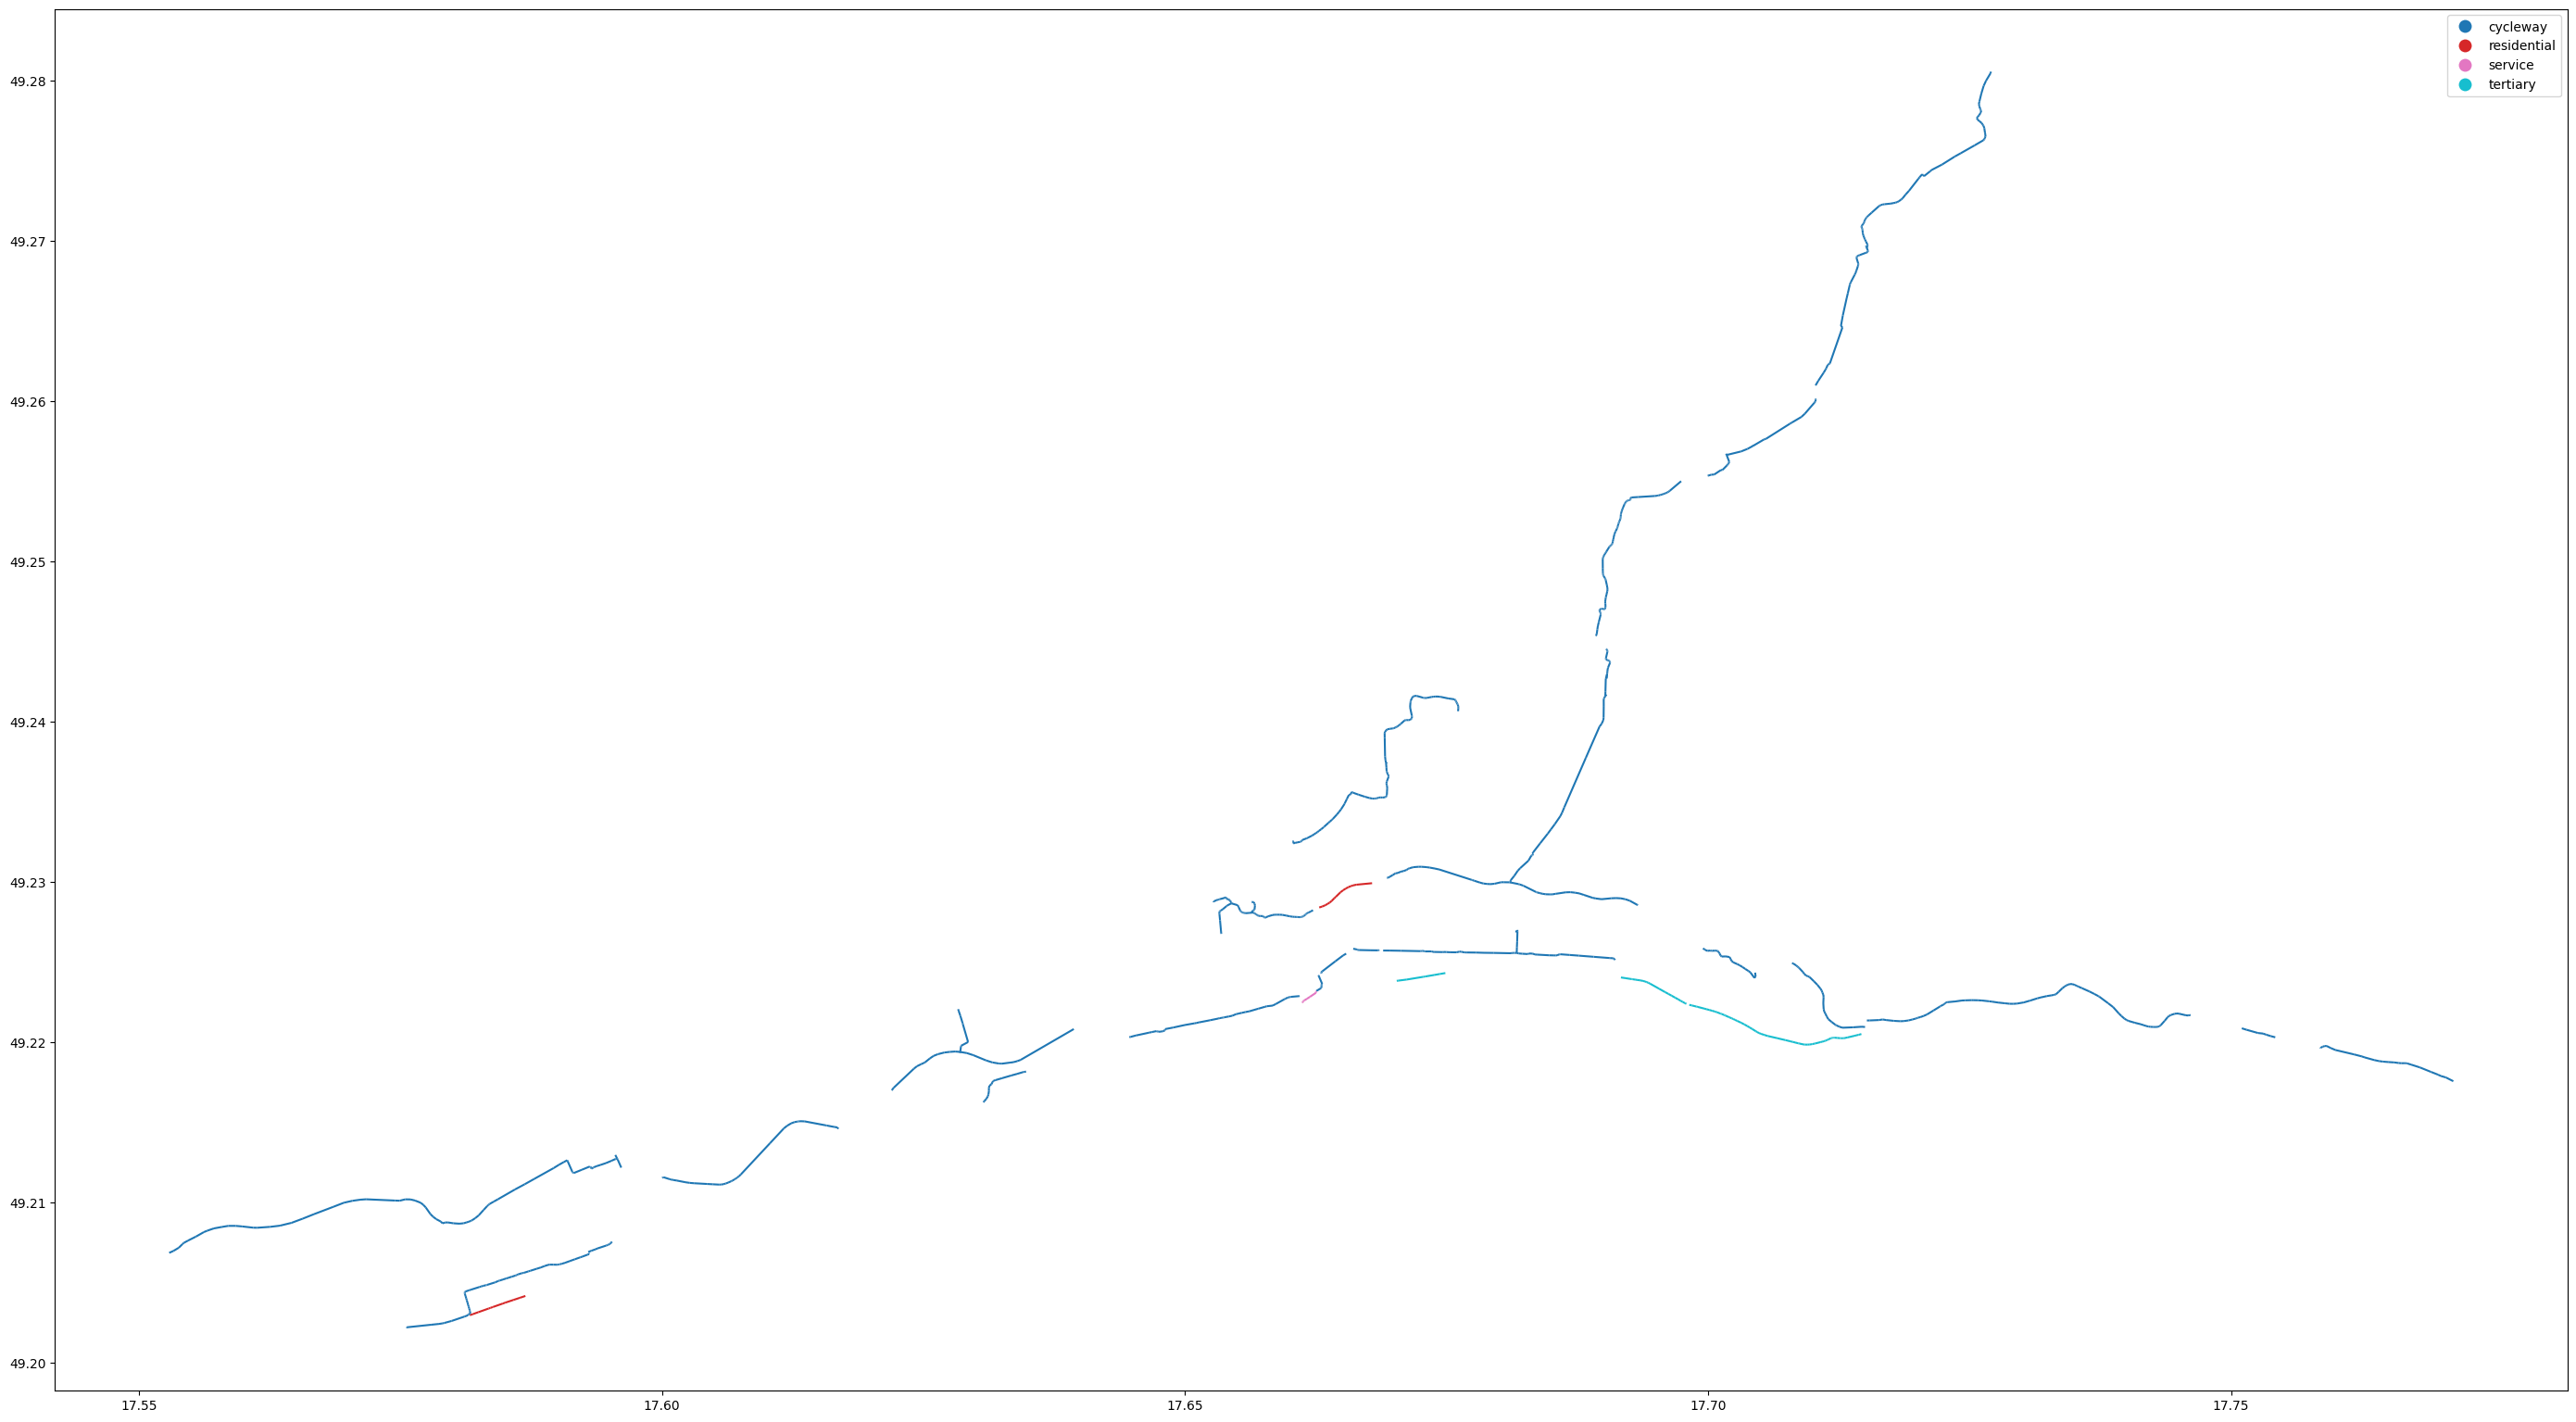

In [31]:
plt = subset.plot(figsize=(35,35), column="highway", legend=True)
plt

In [32]:
m = subset.explore()
m.save(f"{osm_city}.html")
m

In [ ]:
m = lanes.explore()
m.save(f"{osm_city}_lanes.html")
m

In [33]:
paths = subset[subset["highway"].isin(["path", "footway"])]

In [34]:
expanded = paths.explode()

/tmp/ipykernel_94125/3867208203.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  expanded = paths.explode()


In [35]:
way_to_coef = {}
i = 0

for w in way_ids:
    coef = way_ids[w]["weighted_distance"] / way_ids[w]["raw_distance"]
    way_to_coef[w] = coef

In [36]:
way_ids

{24390378: {'raw_distance': 102.04454177289836,
  'dist_from_centr': 6.554688926819536,
  'weighted_distance': 9.253361972879782},
 25773539: {'raw_distance': 2379.7254333087662,
  'dist_from_centr': 6.659709479031177,
  'weighted_distance': 206.69814854762703},
 26415825: {'raw_distance': 248.25234799394525,
  'dist_from_centr': 2.0360056985390838,
  'weighted_distance': 143.55000259761172},
 33878417: {'raw_distance': 23.29392117212187,
  'dist_from_centr': 0.9673547728750103,
  'weighted_distance': 20.87551572359821},
 34225465: {'raw_distance': 311.1023904366177,
  'dist_from_centr': 1.6479551022463153,
  'weighted_distance': 210.91611512381652},
 36994957: {'raw_distance': 8.902931054035122,
  'dist_from_centr': 0.6528721550672193,
  'weighted_distance': 8.902931054035122},
 38193579: {'raw_distance': 174.88205713637007,
  'dist_from_centr': 5.075223312518359,
  'weighted_distance': 29.08638599129433},
 38193581: {'raw_distance': 454.47948365744867,
  'dist_from_centr': 4.79947604

In [22]:
way_to_coef

{36839967: 0.7871605245601208,
 167475333: 0.862761314273823,
 167475449: 0.8421861837716031,
 168078135: 0.34460411132898505,
 168078137: 0.42235941644849373,
 168078147: 0.4180413980816941,
 168078148: 0.37862339467371303,
 168078149: 0.34097767355401654,
 168078151: 0.34224859907181426,
 168078152: 0.3489673767041904,
 168078160: 0.43069051823154336,
 168078161: 0.3225541645507348,
 216859357: 0.853590911462705,
 216859358: 0.9145302627431448,
 216859360: 0.8819218721821211,
 216859362: 0.8506205939589802,
 228527261: 1.0,
 255997488: 0.2903592897640941,
 255997506: 0.3502018115580313,
 255997516: 0.718365685592293,
 259713453: 0.9160779814262674,
 266946218: 0.8766558002743575,
 277788024: 0.2978791284791115,
 277788042: 0.3029932308182571,
 277788053: 0.29800312820212604,
 277788057: 0.3060944244678075,
 277788072: 0.303822293900395,
 277788073: 0.30284920820999883,
 277788096: 0.4168912298900044,
 277788126: 0.31377919816967725,
 296151466: 0.22445751549271967,
 303011508: 0.4061

In [37]:
# way_ids_for_viz = [24773942, 162582750, 65180197, 214469336, 91896352, 213878646]
way_ids_for_viz = list(way_ids.keys())

In [38]:
for w in way_ids_for_viz:
     print(w, way_to_coef[w])

24390378 0.0906796366774156
25773539 0.0868579818724021
26415825 0.5782422754813696
33878417 0.8961786883945497
34225465 0.677963659577818
36994957 1.0
38193579 0.16632001285651196
38193581 0.18622769657557564
38193585 0.24966704465931314
38196231 0.29473994310897655
38196238 0.35591314215405123
38196346 0.4202349820663303
38196533 0.4579523955371242
38196534 0.4830548817702599
38196535 0.4667803587169419
38196538 0.4799824554549652
38196629 0.5650305722103446
38196630 0.7269904354244453
38196631 0.8140521854927268
38288174 0.22424306300307154
38289580 0.502887745147848
38289991 0.9251395137241596
38555235 0.40686907234600667
38749298 0.3577458654710591
38749339 0.4489766008046461
38750550 0.4065898855330313
38751893 0.855955236569034
38784262 0.31003354035838454
38958602 0.8787290490401457
38958604 0.8384679148465704
40631281 0.41636141117571696
40690294 0.4254632944280283
53272391 0.7333773678466811
54465686 0.429764990206688
54465688 0.483459485312257
54465699 0.429825194414097
5578

In [39]:
cycle_roads = drive_net[drive_net.id.isin(way_ids_for_viz)]

In [40]:
expanded = cycle_roads.explode()

/tmp/ipykernel_94125/4065863413.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  expanded = cycle_roads.explode()


In [41]:
way_to_coord = {}

In [49]:
lngs = []
lats = []
ids = []
for geom, way_id in zip(expanded["geometry"], expanded["id"]):
    (start_lng, start_lat), (end_lng, end_lat) = geom.coords
    if way_id not in way_to_coord:
        way_to_coord[way_id] = (start_lat, start_lng)
    lngs.append((start_lng, end_lng))
    lats.append((start_lat, end_lat))
    ids.append(way_id)

In [83]:
from shapely.geometry import Point, shape, Polygon, MultiPolygon
from functools import partial
import random
import pyproj
from shapely.ops import transform
import matplotlib.pyplot as plt

In [84]:
proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]

def create_circle_around_coord(lat, lon, km):
    b = geodesic_point_buffer(lat, lon, km)
    circle_lats = [x[1] for x in b]
    circle_lngs = [x[0] for x in b]
    return circle_lats, circle_lngs, b

In [85]:
# city_centroid = (13.3746469, 49.7492219)
city_centroid = city_data[list(city_data.keys())[0]]

for c in city_centroid:
    # if c is the same as dict key
    if list(c.keys())[0] == osm_city:
        city_centroid = c[osm_city]["centre"]
        break
print(city_centroid)
circle = create_circle_around_coord(city_centroid[0], city_centroid[1], 8)

[49.22678, 17.66672]


/home/dan/pex/venv3.10/lib/python3.10/site-packages/shapely/ops.py:305: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  zip(*func(*zip(*geom.exterior.coords))))


100%|██████████| 1351/1351 [00:00<00:00, 1488.66it/s]


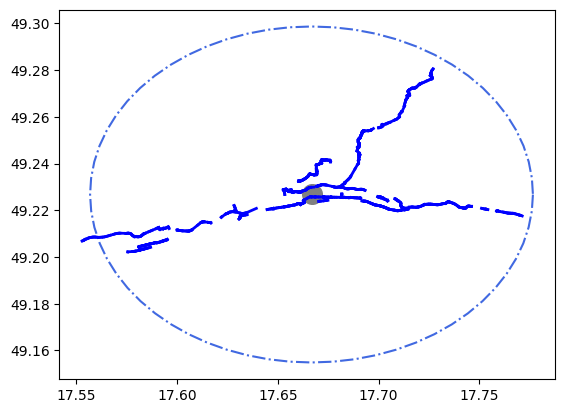

In [87]:
plt.scatter(city_centroid[1], city_centroid[0], color='gray', marker='o', s=200)
plt.plot(circle[1], circle[0], '-.', color="royalblue")
for i in tqdm.tqdm(range(len(lngs))):
#     color = str(color_map(way_to_coef[ids[i]]))
     color = "blue"
     plt.plot(lngs[i], lats[i], linewidth=2.0, color=color)
# mplleaflet.show(tiles="cartodb_positron")
# mplleaflet.show()
plt.show()

## European map

In [ ]:
from city_conf import city_mappings

In [ ]:
city_centres = {}
for country in city_mappings:
    for city in city_mappings[country]:
        city_name = list(city.keys())[0]
        city_centre = city[city_name]['centre']
        city_centres[city_name] = city_centre

In [ ]:
from bs4 import BeautifulSoup
import requests

In [ ]:
html = "https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits"

In [ ]:
parsed_html = BeautifulSoup(requests.get(html).text)

In [ ]:
table = parsed_html.find('table')

In [ ]:
df = pd.read_html(html)[0]

In [ ]:
cities = []
pops = []
shares = []

for city_name, pop in zip(df["City"], df["Officialpopulation"]):
    if (city_name in city_centres) and (city_name in final["City name"].values):
        cities.append(city_name)
        pops.append(np.log(pop))
        shares.append(final[final["City name"] == city_name]["Cycle road share (weighted)"].iloc[0])

In [ ]:
plt.scatter(pops, shares)
m, b = np.polyfit(np.array(pops), np.array(shares), 1)
plt.plot(pops, m*np.array(pops) + b, '--', color='blue')
plt.xlabel("Log(population)")
plt.ylabel("Cycle road share (weighted)")
plt.show()

In [ ]:
np.exp(13)

In [ ]:
lats = [city_centres[c][0] for c in city_centres]
lngs = [city_centres[c][1] for c in city_centres]
shares = []
for city_name in city_centres:
    shares.append(final[final["city_name"] == city_name]["cycle_road_share_decayed"].iloc[0])
    
plt.scatter(lngs, lats, s=np.array(shares)*3000, alpha=0.6)
mplleaflet.show()